# 02 Dask Dataframe Operations

#### Objectives:
- Demonstrate similarity between Pandas and Dask Dataframes
- Familiarize user with operations on Dask Dataframes
- Read/Write to parquet
- Show a Dask Distributed Dataframe

Original Code: https://examples.dask.org/dataframes/01-data-access.html

#### Create single node instance to run Dask on

In [1]:
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=4, processes=False, memory_limit='2GB')
client

Client Scheduler: inproc://10.0.85.15/196/1 Dashboard: http://10.0.85.15/196/1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


#### Get the Dask Scheduler UI

In [ ]:
import os 
engine_id = os.environ.get('CDSW_ENGINE_ID')
cdsw_domain = os.environ.get('CDSW_DOMAIN')

from IPython.core.display import HTML
HTML('<a  target="_blank" rel="noopener noreferrer" href="http://read-only-{}.{}">http://read-only-{}.{}</a>'
     .format(engine_id,cdsw_domain,engine_id,cdsw_domain))

#### Import data into Pandas Dataframe

In [ ]:
import pandas as pd

df = pd.read_csv('data/2000-01-01.csv')
df.head()

#### Import data into Dask Dataframe

In [2]:
import dask
df = dask.datasets.timeseries()
df

,id,name,x,y
npartitions=30,,,,
2000-01-01,int64,object,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


In [ ]:
## Optionally perist data in memory for faster computation
## df = df.persist()

#### Write files to CSV

In [3]:
import os
import datetime

if not os.path.exists('data'):
    os.mkdir('data')

def name(i):
    """ Provide date for filename given index

    Examples
    --------
    >>> name(0)
    '2000-01-01'
    >>> name(10)
    '2000-01-11'
    """
    return str(datetime.date(2000, 1, 1) + i * datetime.timedelta(days=1))

df.to_csv('data/*.csv', name_function=name);

In [4]:
!ls data/*.csv | head

data/2000-01-01.csv
data/2000-01-02.csv
data/2000-01-03.csv
data/2000-01-04.csv
data/2000-01-05.csv
data/2000-01-06.csv
data/2000-01-07.csv
data/2000-01-08.csv
data/2000-01-09.csv
data/2000-01-10.csv


#### Import datasets into Dask dataframe

In [5]:
import dask.dataframe as dd

df = dd.read_csv('data/2000-*-*.csv')
df

,timestamp,id,name,x,y
npartitions=30,,,,,
,object,int64,object,float64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


#### Notice that just like Spark, Dask has lazy execution and it has not executed the DAG yet

In [6]:
df.head()

,timestamp,id,name,x,y
0,2000-01-01 00:00:00,994,Bob,0.596320,-0.391068
1,2000-01-01 00:00:01,1027,Tim,-0.508183,-0.350446
2,2000-01-01 00:00:02,993,Quinn,0.867110,0.609114
3,2000-01-01 00:00:03,1049,Patricia,0.382109,-0.637209
4,2000-01-01 00:00:04,1001,Wendy,0.288870,0.990427


#### The data operation has now been executed

#### Timing GroupBy Operation

In [7]:
%time df.groupby('name').x.mean().compute()

CPU times: user 3.25 s, sys: 522 ms, total: 3.77 s
Wall time: 2.11 s


name
Alice       0.001382
Bob         0.003097
Charlie    -0.000105
Dan        -0.001558
Edith      -0.000485
Frank       0.000451
George     -0.001747
Hannah     -0.000766
Ingrid     -0.000645
Jerry      -0.003618
Kevin       0.002080
Laura      -0.000172
Michael    -0.001756
Norbert    -0.003623
Oliver      0.001927
Patricia    0.001078
Quinn       0.000304
Ray        -0.000328
Sarah      -0.000369
Tim        -0.000167
Ursula      0.000413
Victor      0.001920
Wendy      -0.000781
Xavier      0.000826
Yvonne     -0.001173
Zelda       0.002948
Name: x, dtype: float64

#### Writing to parquet

In [9]:
df.to_parquet('data/2000-01.parquet', engine='pyarrow')

#### Reading from parquet

In [11]:
df = dd.read_parquet('data/2000-01.parquet', engine='pyarrow')
df.groupby('name').x.mean().compute()

name
Alice       0.001382
Bob         0.003097
Charlie    -0.000105
Dan        -0.001558
Edith      -0.000485
Frank       0.000451
George     -0.001747
Hannah     -0.000766
Ingrid     -0.000645
Jerry      -0.003618
Kevin       0.002080
Laura      -0.000172
Michael    -0.001756
Norbert    -0.003623
Oliver      0.001927
Patricia    0.001078
Quinn       0.000304
Ray        -0.000328
Sarah      -0.000369
Tim        -0.000167
Ursula      0.000413
Victor      0.001920
Wendy      -0.000781
Xavier      0.000826
Yvonne     -0.001173
Zelda       0.002948
Name: x, dtype: float64

#### For more on efficient data storage with Dask Dataframes: https://github.com/dask/dask-tutorial/blob/master/07_dataframe_storage.ipynb

#### Next we will create a Dask Distributed Dataframe with a Dask Multinode Cluster

In [13]:
import cdsw_dask_utils
import cdsw

# Run a Dask cluster with three workers and return an object containing
# a description of the cluster. 
# 
# Note that the scheduler will run in the current session, and the Dask
# dashboard will become available in the nine-dot menu at the upper
# right corner of the CDSW app.

new_cluster = cdsw_dask_utils.run_dask_cluster(
  n=2, \
  cpu=1, \
  memory=2, \
  nvidia_gpu=0
)

# Connect a Dask client to the scheduler address in the cluster
# description.
from dask.distributed import Client
client = Client(new_cluster["scheduler_address"])

Waiting for Dask scheduler to become ready...
Dask scheduler is ready
IDs ['ewv817pqoounba76', 'yj2dseulbg7jul1o']


In [14]:
df = dd.read_parquet('data/2000-01.parquet', engine='pyarrow')

#### Similar to Spark, Dask uses a DAG to optimize computation. You can visualize the DAG.

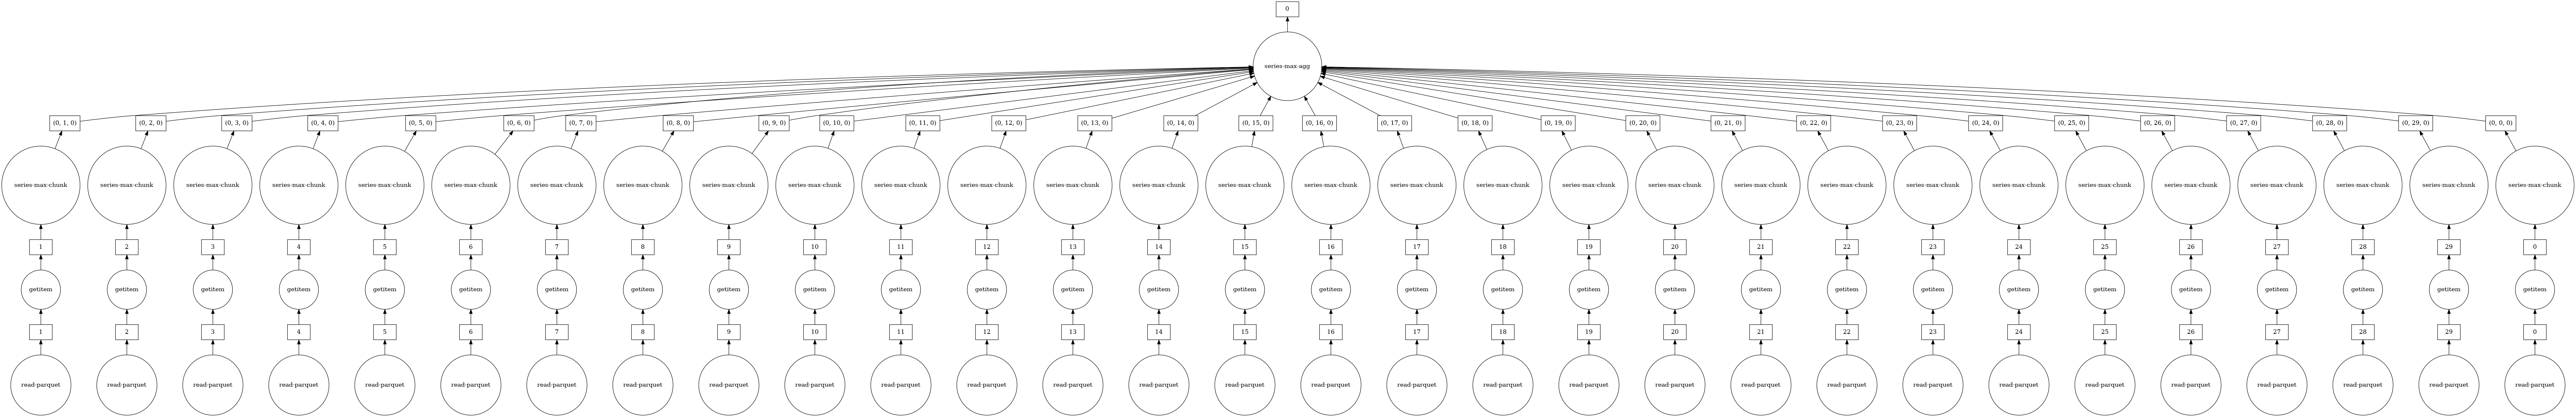

In [21]:
df.x.max().visualize()

#### For more on the Dask Delayed API: https://docs.dask.org/en/latest/delayed.html

#### Stopping CDSW Workers

In [22]:
## stop CDSW workers
#Parameter
#worker_id (int, optional) - The ID numbers of the worker engines that must be stopped. 
#If an ID is not provided, all the worker engines on the cluster will be stopped.

cdsw.stop_workers()

[<Response [204]>,
 <Response [204]>,
 <Response [204]>,
 <Response [204]>,
 <Response [204]>,
 <Response [204]>,
 <Response [204]>,
 <Response [204]>]

#### Next we will use SciKit Learn with Dask for Machine Learning